# Gene Expression Monitoring Analysis

## Data Preparation

In [1]:
# Import all the libraries that we shall be using
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [2]:
!pip install boruta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.5 MB/s eta 0:00:00


In [3]:
# Import labels (for the whole dataset, both training and testing)
y = pd.read_csv('/content/actual.csv')
print(y.shape)
y.head()

(72, 2)


,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


In [4]:
y['cancer'].value_counts()

ALL    47
AML    25
Name: cancer, dtype: int64

In [5]:
# Recode label to numeric
y = y.replace({'ALL':0,'AML':1})
labels = ['ALL', 'AML'] # for plotting convenience later on

In [6]:
# unzip data

!unzip /content/data_set_ALL_AML_independent.csv.zip
!unzip /content/data_set_ALL_AML_train.csv.zip

Archive:  /content/data_set_ALL_AML_independent.csv.zip
  inflating: data_set_ALL_AML_independent.csv  
Archive:  /content/data_set_ALL_AML_train.csv.zip
  inflating: data_set_ALL_AML_train.csv  


In [7]:
# Import training data
df_train = pd.read_csv('/content/data_set_ALL_AML_train.csv')
print(df_train.shape)

# Import testing data
df_test = pd.read_csv('/content/data_set_ALL_AML_independent.csv')
print(df_test.shape)

(7129, 78)
(7129, 70)


In [8]:
df_train.head()

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,...,2,A,-95,A,49,A,-37,A,-70,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,...,193,A,312,A,230,P,330,A,337,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [9]:
df_test.head()

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-342,A,-87,A,22,A,-243,A,...,-62,A,-58,A,-161,A,-48,A,-176,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-200,A,-248,A,-153,A,-218,A,...,-198,A,-217,A,-215,A,-531,A,-284,A
2,AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,41,A,262,A,17,A,-163,A,...,-5,A,63,A,-46,A,-124,A,-81,A
3,AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,328,A,295,A,276,A,182,A,...,141,A,95,A,146,A,431,A,9,A
4,AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-224,A,-226,A,-211,A,-289,A,...,-256,A,-191,A,-172,A,-496,A,-294,A


In [10]:
# Transform all the call values to numbers (not used in this version)
# df_train.replace(['A','P','M'],['1','2','3'], inplace=True)
# df_test.replace(['A','P','M'],['1','2','3'], inplace=True)

# Remove "call" columns from training and testing data
train_to_keep = [col for col in df_train.columns if "call" not in col]
test_to_keep = [col for col in df_test.columns if "call" not in col]

X_train_tr = df_train[train_to_keep]
X_test_tr = df_test[test_to_keep]

In [11]:
train_columns_titles = ['Gene Description', 'Gene Accession Number', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38']

X_train_tr = X_train_tr.reindex(columns=train_columns_titles)

In [12]:
test_columns_titles = ['Gene Description', 'Gene Accession Number','39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53',  '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72']

X_test_tr = X_test_tr.reindex(columns=test_columns_titles)

In [13]:
X_train = X_train_tr.T
X_test = X_test_tr.T

print(X_train.shape)
X_train.head()

(40, 7129)


,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
Gene Description,AFFX-BioB-5_at (endogenous control),AFFX-BioB-M_at (endogenous control),AFFX-BioB-3_at (endogenous control),AFFX-BioC-5_at (endogenous control),AFFX-BioC-3_at (endogenous control),AFFX-BioDn-5_at (endogenous control),AFFX-BioDn-3_at (endogenous control),AFFX-CreX-5_at (endogenous control),AFFX-CreX-3_at (endogenous control),AFFX-BioB-5_st (endogenous control),...,Transcription factor Stat5b (stat5b) mRNA,Breast epithelial antigen BA46 mRNA,GB DEF = Calcium/calmodulin-dependent protein ...,TUBULIN ALPHA-4 CHAIN,CYP4B1 Cytochrome P450; subfamily IVB; polypep...,PTGER3 Prostaglandin E receptor 3 (subtype EP3...,HMG2 High-mobility group (nonhistone chromosom...,RB1 Retinoblastoma 1 (including osteosarcoma),GB DEF = Glycophorin Sta (type A) exons 3 and ...,GB DEF = mRNA (clone 1A7)
Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41


In [14]:
# Clean up the column names for training and testing data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for Testing data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

print(X_train.shape)
print(X_test.shape)
X_train.head()

(38, 7129)
(34, 7129)


Gene Accession Number,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [15]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import math

In [17]:
# Split into train and test (we first need to reset the index as the indexes of two dataframes need to be the same before you combine them).

# Subset the first 38 patient's cancer types
X_train = X_train.reset_index(drop=True)
#X_train_v2 = X_train_v2.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subset the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)

In [18]:
y_train.head()

,patient,cancer
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [19]:
# Ajusting y_train e test

y_train.set_index('patient', inplace=True)
y_test.set_index('patient', inplace=True)


In [20]:
y_train= pd.DataFrame(y_train)
y_test= pd.DataFrame(y_test)

Selecting the best features using Boruta

##BorutaPY

The Boruta library is an effective tool for automatic feature selection in datasets. Specifically designed to work with tree-based models, such as Random Forests, Boruta helps identify the most important features in a dataset.

The Boruta process involves creating random shadows for existing features and then training a tree-based model (such as a Random Forest) using these shadows as well as the original features. Original features are considered important if they significantly outperform their shadows in terms of importance.

At the end of the process, Boruta classifies features into three categories: those deemed important, those deemed unimportant, and those with uncertain importance. This provides a clear view of the most influential features for the model.

To integrate Boruta into your script, you'll need to follow several steps, including initializing the Boruta selector, fitting it to the training data, and visualizing the selected features. This can be particularly useful before applying complex models, helping to reduce the dimensionality of your dataset and enhance model performance.

In [21]:
# RF model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# create BorutaPy
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# Ajust BorutaPy to train
boruta.fit(X_train.values, y_train)

# See selected features
selected_features = X_train.columns[boruta.support_]
print("Features Selecionadas:", selected_features)

# Selecting only the features from BorutaPy
X_train_selected = boruta.transform(X_train.values)
X_test_selected = boruta.transform(X_test.values)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	7129
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	7129
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	7129
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	7129
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	7129
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	7129
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	7129
Rejected: 	0


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	106
Rejected: 	7023


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	9 / 100
Confirmed: 	26
Tentative: 	80
Rejected: 	7023


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	10 / 100
Confirmed: 	26
Tentative: 	80
Rejected: 	7023


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	11 / 100
Confirmed: 	26
Tentative: 	80
Rejected: 	7023


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	12 / 100
Confirmed: 	30
Tentative: 	58
Rejected: 	7041


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	13 / 100
Confirmed: 	30
Tentative: 	58
Rejected: 	7041


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	14 / 100
Confirmed: 	30
Tentative: 	58
Rejected: 	7041


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	15 / 100
Confirmed: 	30
Tentative: 	58
Rejected: 	7041


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	16 / 100
Confirmed: 	31
Tentative: 	47
Rejected: 	7051


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	17 / 100
Confirmed: 	31
Tentative: 	47
Rejected: 	7051


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	18 / 100
Confirmed: 	31
Tentative: 	47
Rejected: 	7051


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	19 / 100
Confirmed: 	31
Tentative: 	42
Rejected: 	7056


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	20 / 100
Confirmed: 	31
Tentative: 	42
Rejected: 	7056


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	21 / 100
Confirmed: 	31
Tentative: 	42
Rejected: 	7056


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	22 / 100
Confirmed: 	31
Tentative: 	42
Rejected: 	7056


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	23 / 100
Confirmed: 	31
Tentative: 	40
Rejected: 	7058


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	24 / 100
Confirmed: 	31
Tentative: 	40
Rejected: 	7058


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	25 / 100
Confirmed: 	31
Tentative: 	40
Rejected: 	7058


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	26 / 100
Confirmed: 	31
Tentative: 	40
Rejected: 	7058


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	27 / 100
Confirmed: 	31
Tentative: 	40
Rejected: 	7058


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	28 / 100
Confirmed: 	31
Tentative: 	40
Rejected: 	7058


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	29 / 100
Confirmed: 	31
Tentative: 	38
Rejected: 	7060


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	30 / 100
Confirmed: 	31
Tentative: 	38
Rejected: 	7060


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	31 / 100
Confirmed: 	31
Tentative: 	38
Rejected: 	7060


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	32 / 100
Confirmed: 	31
Tentative: 	36
Rejected: 	7062


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	33 / 100
Confirmed: 	31
Tentative: 	36
Rejected: 	7062


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	34 / 100
Confirmed: 	31
Tentative: 	36
Rejected: 	7062


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	35 / 100
Confirmed: 	31
Tentative: 	36
Rejected: 	7062


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	36 / 100
Confirmed: 	31
Tentative: 	36
Rejected: 	7062


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	37 / 100
Confirmed: 	31
Tentative: 	34
Rejected: 	7064


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	38 / 100
Confirmed: 	31
Tentative: 	34
Rejected: 	7064


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	39 / 100
Confirmed: 	31
Tentative: 	34
Rejected: 	7064


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	40 / 100
Confirmed: 	31
Tentative: 	32
Rejected: 	7066


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	41 / 100
Confirmed: 	31
Tentative: 	32
Rejected: 	7066


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	42 / 100
Confirmed: 	31
Tentative: 	32
Rejected: 	7066


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	43 / 100
Confirmed: 	31
Tentative: 	30
Rejected: 	7068


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	44 / 100
Confirmed: 	31
Tentative: 	30
Rejected: 	7068


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	45 / 100
Confirmed: 	31
Tentative: 	30
Rejected: 	7068


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	46 / 100
Confirmed: 	31
Tentative: 	29
Rejected: 	7069


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	47 / 100
Confirmed: 	31
Tentative: 	29
Rejected: 	7069


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	48 / 100
Confirmed: 	31
Tentative: 	29
Rejected: 	7069


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	49 / 100
Confirmed: 	31
Tentative: 	28
Rejected: 	7070


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	50 / 100
Confirmed: 	31
Tentative: 	28
Rejected: 	7070


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	51 / 100
Confirmed: 	31
Tentative: 	27
Rejected: 	7071


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	52 / 100
Confirmed: 	31
Tentative: 	27
Rejected: 	7071


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	53 / 100
Confirmed: 	31
Tentative: 	27
Rejected: 	7071


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	54 / 100
Confirmed: 	31
Tentative: 	25
Rejected: 	7073


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	55 / 100
Confirmed: 	31
Tentative: 	25
Rejected: 	7073


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	56 / 100
Confirmed: 	31
Tentative: 	25
Rejected: 	7073
Iteration: 	57 / 100
Confirmed: 	31
Tentative: 	25
Rejected: 	7073


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	58 / 100
Confirmed: 	31
Tentative: 	25
Rejected: 	7073


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	59 / 100
Confirmed: 	31
Tentative: 	24
Rejected: 	7074


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	60 / 100
Confirmed: 	31
Tentative: 	24
Rejected: 	7074


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	61 / 100
Confirmed: 	31
Tentative: 	24
Rejected: 	7074


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	62 / 100
Confirmed: 	31
Tentative: 	22
Rejected: 	7076


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	63 / 100
Confirmed: 	31
Tentative: 	22
Rejected: 	7076


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	64 / 100
Confirmed: 	31
Tentative: 	22
Rejected: 	7076


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	65 / 100
Confirmed: 	31
Tentative: 	22
Rejected: 	7076


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	66 / 100
Confirmed: 	31
Tentative: 	22
Rejected: 	7076


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	67 / 100
Confirmed: 	31
Tentative: 	21
Rejected: 	7077


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	68 / 100
Confirmed: 	31
Tentative: 	21
Rejected: 	7077


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	69 / 100
Confirmed: 	31
Tentative: 	21
Rejected: 	7077


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	70 / 100
Confirmed: 	31
Tentative: 	21
Rejected: 	7077
Iteration: 	71 / 100
Confirmed: 	31
Tentative: 	21
Rejected: 	7077


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	72 / 100
Confirmed: 	31
Tentative: 	20
Rejected: 	7078


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	73 / 100
Confirmed: 	31
Tentative: 	20
Rejected: 	7078


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	74 / 100
Confirmed: 	31
Tentative: 	20
Rejected: 	7078


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	75 / 100
Confirmed: 	31
Tentative: 	19
Rejected: 	7079


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	76 / 100
Confirmed: 	31
Tentative: 	19
Rejected: 	7079


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	77 / 100
Confirmed: 	31
Tentative: 	19
Rejected: 	7079


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	78 / 100
Confirmed: 	31
Tentative: 	19
Rejected: 	7079
Iteration: 	79 / 100
Confirmed: 	31
Tentative: 	19
Rejected: 	7079


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	80 / 100
Confirmed: 	31
Tentative: 	18
Rejected: 	7080


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	81 / 100
Confirmed: 	31
Tentative: 	18
Rejected: 	7080


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	82 / 100
Confirmed: 	31
Tentative: 	18
Rejected: 	7080


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	83 / 100
Confirmed: 	31
Tentative: 	17
Rejected: 	7081


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	84 / 100
Confirmed: 	31
Tentative: 	17
Rejected: 	7081


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	85 / 100
Confirmed: 	31
Tentative: 	17
Rejected: 	7081
Iteration: 	86 / 100
Confirmed: 	31
Tentative: 	17
Rejected: 	7081


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	87 / 100
Confirmed: 	31
Tentative: 	17
Rejected: 	7081
Iteration: 	88 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082

/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)



Iteration: 	89 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	90 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082
Iteration: 	91 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	92 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	93 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082
Iteration: 	94 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	95 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082
Iteration: 	96 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082
Iteration: 	97 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	98 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082


/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.10/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)


Iteration: 	99 / 100
Confirmed: 	31
Tentative: 	16
Rejected: 	7082


BorutaPy finished running.

Iteration: 	100 / 100
Confirmed: 	31
Tentative: 	3
Rejected: 	7082
Features Selecionadas: Index(['D14874_at', 'D49950_at', 'D88422_at', 'J04615_at', 'J05243_at',
       'M16038_at', 'M21551_rna1_at', 'M23197_at', 'M27891_at', 'M31166_at',
       'M31303_rna1_at', 'M54995_at', 'M55150_at', 'M77142_at', 'M81933_at',
       'M84526_at', 'M92287_at', 'U02020_at', 'U46499_at', 'U46751_at',
       'U50136_rna1_at', 'X62654_rna1_at', 'X70297_at', 'X95735_at',
       'Y12670_at', 'U22376_cds2_s_at', 'L09209_s_at', 'M27783_s_at',
       'M83652_s_at', 'M98399_s_at', 'M31523_at'],
      dtype='object', name='Gene Accession Number')


In [ ]:
# Print Selected Features
selected_features = X_train.columns[boruta.support_]
print("Features Selecionadas:", selected_features)

# New dataframe with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [23]:
# Normalizing data
from sklearn.preprocessing import StandardScaler

padronizador = StandardScaler()
padronizador.fit(X_train_selected)
X_train_v1 = padronizador.transform(X_train_selected)

In [24]:
padronizador = StandardScaler()
padronizador.fit(X_test_selected)
X_test_v1 = padronizador.transform(X_test_selected)

In [25]:
X_test_v1 = pd.DataFrame(data = X_test_v1,
                                columns = X_test_selected.keys())


In [27]:
X_train_v1 = pd.DataFrame(data = X_train_v1,
                                columns = X_train_selected.keys())

In [28]:
X_train_v1.describe()

Gene Accession Number,D14874_at,D49950_at,D88422_at,J04615_at,J05243_at,M16038_at,M21551_rna1_at,M23197_at,M27891_at,M31166_at,...,X62654_rna1_at,X70297_at,X95735_at,Y12670_at,U22376_cds2_s_at,L09209_s_at,M27783_s_at,M83652_s_at,M98399_s_at,M31523_at
count,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,...,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01,3.800000e+01
mean,7.559742e-17,-4.674623e-17,-2.191230e-17,5.843279e-17,-4.382459e-17,1.342128e-17,1.051790e-16,6.427607e-17,-7.304099e-18,-1.168656e-17,...,6.865853e-17,8.764919e-18,-5.989361e-17,-8.180591e-17,7.596263e-17,6.537168e-17,-1.497340e-17,-3.798131e-17,7.596263e-17,-7.888427e-17
std,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,...,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00,1.013423e+00
min,-1.337561e+00,-1.161543e+00,-4.380822e-01,-1.292772e+00,-1.196636e+00,-9.327349e-01,-2.054660e+00,-8.277556e-01,-5.743483e-01,-5.324919e-01,...,-7.945182e-01,-9.067128e-01,-1.219171e+00,-1.009581e+00,-1.257476e+00,-9.523288e-01,-4.955563e-01,-9.955743e-01,-9.259198e-01,-1.028545e+00
25%,-6.297264e-01,-8.021481e-01,-3.931723e-01,-6.633446e-01,-7.034178e-01,-6.155153e-01,-5.901550e-01,-5.946142e-01,-5.127614e-01,-3.719613e-01,...,-5.415073e-01,-4.718090e-01,-5.859764e-01,-7.677701e-01,-8.574432e-01,-6.204025e-01,-3.495136e-01,-6.951589e-01,-5.245333e-01,-7.380745e-01
50%,-2.057094e-01,-2.345523e-01,-3.453986e-01,-1.764021e-01,-2.678483e-01,-3.179728e-01,1.876302e-01,-4.131227e-01,-4.312832e-01,-3.257598e-01,...,-3.061648e-01,-3.032001e-01,-3.186274e-01,-1.547630e-01,1.489080e-02,-3.988159e-01,-2.787868e-01,-3.225832e-01,-3.567062e-01,-3.385357e-01
75%,2.217270e-01,5.982519e-01,-1.585994e-01,3.691254e-01,4.079250e-01,5.410433e-02,5.399474e-01,8.257167e-02,-1.751542e-01,-1.902876e-01,...,-3.053836e-02,2.896072e-01,2.031863e-01,2.251561e-01,7.012634e-01,8.301262e-02,-1.787705e-01,3.093904e-01,-2.171447e-03,4.223964e-01
max,3.983168e+00,2.288646e+00,4.565271e+00,3.235631e+00,3.370438e+00,2.900137e+00,2.238833e+00,3.166493e+00,3.412456e+00,5.334316e+00,...,4.556874e+00,5.254201e+00,3.454435e+00,3.626983e+00,2.835494e+00,3.410442e+00,5.458451e+00,3.921970e+00,3.815196e+00,3.977275e+00


In [29]:
# Convert from integer to float
X_train_fl = X_train_v1.astype(float, 64)
X_test_fl = X_test_v1.astype(float, 64)

# Apply the same scaling to both datasets
scaler = StandardScaler()
X_train_scl = scaler.fit_transform(X_train_fl)
X_test_scl = scaler.transform(X_test_fl) # note that we transform rather than fit_transform

## Model Building

### Baseline

In [30]:
print("Predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of ", round(1 - np.mean(y_test), 3), ".", sep = '')

Predicting everything as acute lymphoblastic leukemia (ALL) results in an accuracy of cancer    0.588
dtype: float64.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


### Random Forest

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Best Parameters:
 {'bootstrap': False, 'max_features': 0.6, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 60}
Random Forest accuracy: 0.912


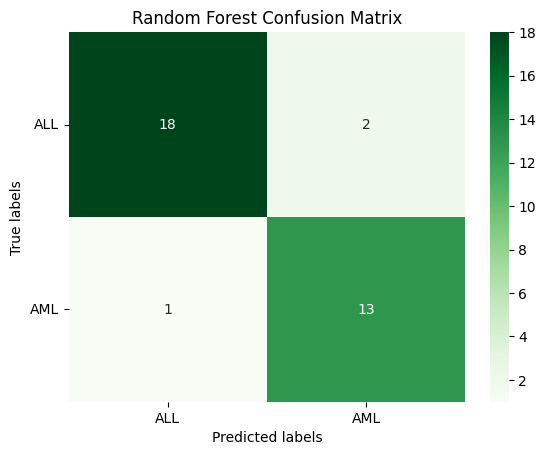

In [31]:
# Hyperparameters search grid
rf_param_grid = {'bootstrap': [False, True],
         'n_estimators': [60, 80,  100],
         'max_features': [0.6,  0.7,  0.8],
         'min_samples_leaf': [8, 10, 14],
         'min_samples_split': [3, 5, 7]
        }

# Instantiate random forest classifier
rf_estimator = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
rf_model = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=3, scoring='roc_auc')

# Fine-tune the hyperparameters
rf_model.fit(X_train, y_train)

print("Best Parameters:\n", rf_model.best_params_)

# Get the best model
rf_model_best = rf_model.best_estimator_

# Make predictions using the optimised parameters
rf_pred = rf_model_best.predict(X_test)

print('Random Forest accuracy:', round(accuracy_score(y_test, rf_pred), 3))

cm_rf = confusion_matrix(y_test, rf_pred)

ax = plt.subplot()
sns.heatmap(cm_rf, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forest Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels, rotation=360);

##ROC_AUC

The ROC Curve (Receiver Operating Characteristic) and AUC-ROC (Area Under the ROC Curve) are common tools for evaluating the performance of binary classification models.

The ROC Curve is a graphical representation illustrating a model's ability to distinguish between positive and negative classes by varying the classification threshold. It plots the true positive rate (sensitivity) on the y-axis against the false positive rate (1 - specificity) on the x-axis. An ideal model will have an ROC curve approaching the top-left corner of the graph.

The AUC-ROC is the numerical measure associated with the ROC Curve and represents the area under this curve. A higher AUC-ROC indicates better model performance in discriminating between classes. A value of 1 indicates a perfect model, while a value of 0.5 suggests performance equivalent to random chance.

In summary, the ROC Curve and AUC-ROC are valuable tools for evaluating the ability of a binary classification model to distinguish between positive and negative classes at different classification thresholds. They provide a comprehensive view of model performance, especially when there is a balance between sensitivity and specificity.

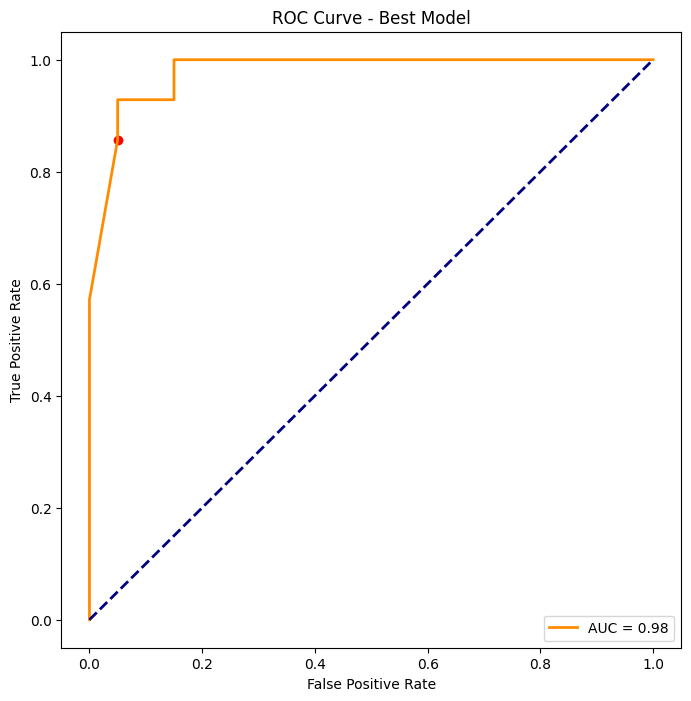

In [32]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class on the test set
y_prob = rf_model_best.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the Area Under the ROC curve (AUC-ROC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Model')
plt.legend(loc='lower right')

# Additionally, plot a point representing the recall at a specific threshold
desired_recall = 0.8  # Set your desired recall value
desired_threshold = thresholds[np.argmax(tpr >= desired_recall)]
plt.scatter(fpr[np.argmax(tpr >= desired_recall)], tpr[np.argmax(tpr >= desired_recall)],
            marker='o', color='red', label=f'Recall = {desired_recall:.2f} at Threshold = {desired_threshold:.2f}')
plt.show()

In [33]:
y_test.head()

,cancer
patient,
39,0
40,0
41,0
42,0
43,0


In [34]:
from sklearn.metrics import roc_auc_score, recall_score

y_true = y_test
y_prob = rf_model_best.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)  # Assuming 0.5 as the threshold, adjust as needed

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_true, y_prob)
print("AUC-ROC RFB: {:.2f}".format(roc_auc))

# Calculate Recall
recall = recall_score(y_true, y_pred)
print("Recall RFB: {:.2f}".format(recall))


AUC-ROC RFB: 0.98
Recall RFB: 0.93


##SHAP

O SHAP (SHapley Additive exPlanations) é uma biblioteca poderosa para explicar as previsões de modelos de machine learning. Aqui estão algumas funções e técnicas importantes fornecidas pela biblioteca SHAP:

1. **`shap_values` e `expected_value`:**
   - `shap_values`: Gera os valores SHAP para explicar as previsões do modelo para cada observação no conjunto de dados.
   - `expected_value`: Retorna os valores esperados das previsões do modelo. Pode ser útil ao interpretar as contribuições das features.

2. **`summary_plot`:**
   - Cria um gráfico de resumo que mostra a contribuição de cada feature para todas as previsões. É útil para identificar quais features têm a maior influência média nas previsões do modelo.

3. **`dependence_plot`:**
   - Gera gráficos de Dependência Individual para visualizar como uma feature específica influencia as previsões do modelo. Ótimo para explorar relações entre features e previsões.

4. **`force_plot`:**
   - Cria gráficos de força para uma observação específica, destacando como as diferentes features contribuem para a diferença entre a previsão do modelo e o valor esperado.

5. **`waterfall_plot`:**
   - Produz gráficos de cascata (waterfall) para uma observação específica, mostrando as contribuições de cada feature para a previsão do modelo em um formato de cascata.

6. **`initjs`:**
   - Inicializa a visualização JavaScript necessária para gráficos interativos no Jupyter Notebook. Pode ser útil para gráficos mais complexos e interativos.

7. **`TreeExplainer`:**
   - Especialização do SHAP para modelos baseados em árvores, como Random Forests e árvores de decisão. Permite explicar as previsões desses modelos de maneira eficiente.

8. **`KernelExplainer`:**
   - Fornecido para modelos de machine learning em geral, não apenas modelos baseados em árvores. Utiliza um kernel SHAP para aproximar os valores SHAP.

Estas são apenas algumas das funções e técnicas oferecidas pelo SHAP. A biblioteca é extremamente flexível e pode ser adaptada a diferentes cenários de interpretação de modelos. Recomendo explorar a documentação oficial do SHAP (https://github.com/slundberg/shap) para obter informações mais detalhadas e exemplos específicos.

In [35]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.4 MB/s eta 0:00:00


In [36]:
# Assuming y_train is a DataFrame with a single column
y_train = y_train.iloc[:, 0].values.ravel()

# Train your Random Forest model
rf_model_best.fit(X_train, y_train)


RandomForestClassifier(bootstrap=False, max_features=0.6, min_samples_leaf=8,
                       min_samples_split=3, n_estimators=60, random_state=42)

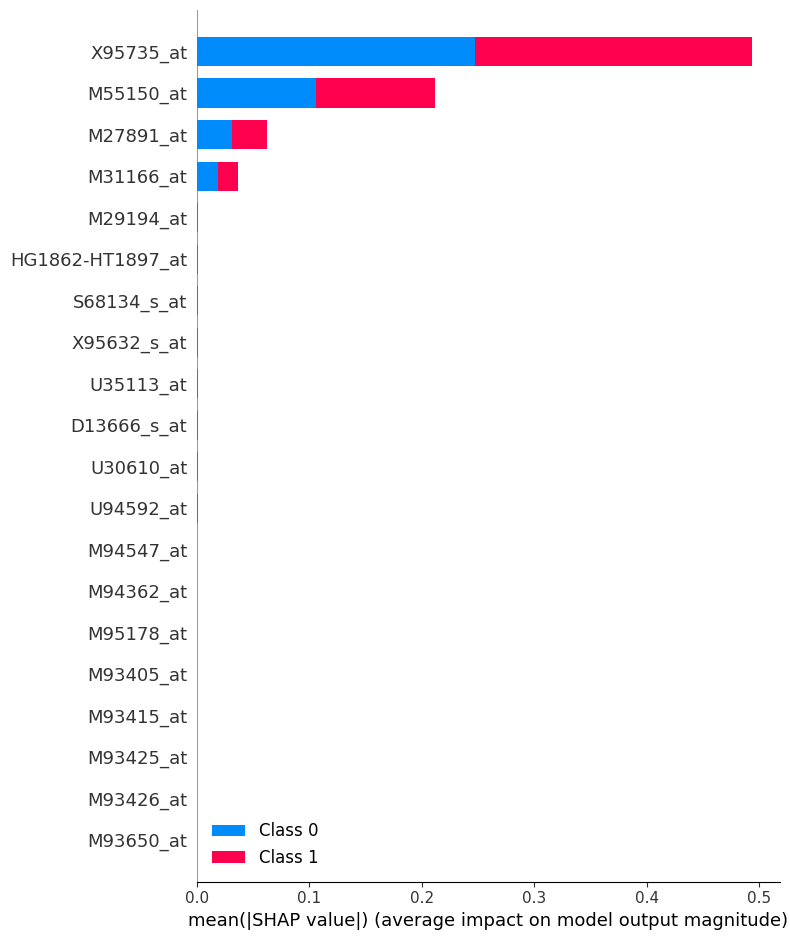

In [37]:
import shap
from sklearn.ensemble import RandomForestClassifier


# Initialize the TreeExplainer
explainer = shap.TreeExplainer(rf_model_best)
shap_values = explainer.shap_values(X_train)

# Plote um resumo de força do SHAP para ter uma visão geral
shap.summary_plot(shap_values, X_train, plot_type="bar")





### Bar Plot:

O Bar Plot é uma versão resumida do Summary Plot, mostrando a média da magnitude do valor SHAP para cada feature.

- **Comprimento das Barras:** A altura das barras no Bar Plot indica a magnitude média da contribuição da feature em todas as observações. Quanto maior a barra, maior a importância média da feature.

- **Orientação da Barra:** A orientação da barra indica se a feature contribuiu positiva ou negativamente para as previsões. Barras à direita (positivas) contribuem positivamente para as previsões, enquanto barras à esquerda (negativas) contribuem negativamente.

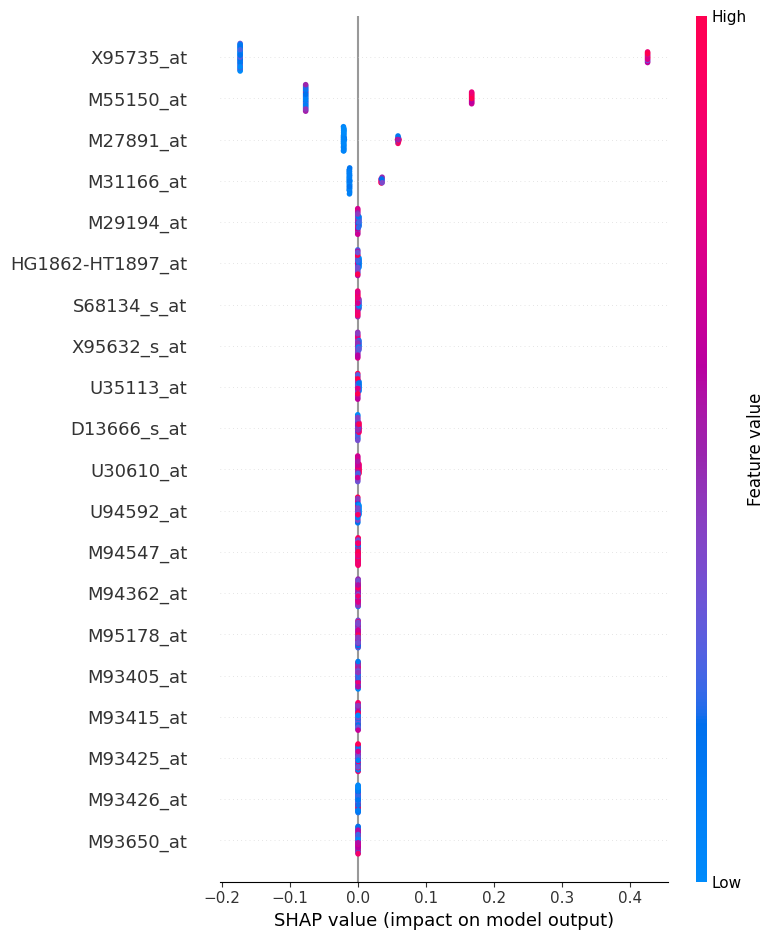

In [39]:
#  Summary plot
shap.summary_plot(shap_values[1], X_train)


### Summary Plot:

O Summary Plot é um gráfico que mostra a importância relativa das features para todas as observações em seu conjunto de dados. Cada ponto representa uma observação, e a posição horizontal do ponto indica o valor do SHAP para aquela feature para a observação específica. As cores dos pontos indicam o valor da feature para ajudar a visualizar a relação.

- **Vertical Spread:** A dispersão vertical dos pontos representa a variabilidade nas contribuições de cada feature para diferentes observações. Features com pontos espalhados verticalmente têm uma influência variável nas previsões, enquanto aquelas com pontos mais concentrados têm uma influência mais consistente.

- **Color Gradient:** A cor dos pontos indica o valor da feature para a observação específica. Isso ajuda a entender como a contribuição da feature muda com os diferentes valores da feature.


### Interpretação Geral:

- **Pontos ou Barras para a Direita (Positivos):** Indicam que valores mais altos dessa feature estão associados a previsões mais altas.

- **Pontos ou Barras para a Esquerda (Negativos):** Indicam que valores mais baixos dessa feature estão associados a previsões mais altas.

- **Variabilidade Vertical:** Maior dispersão vertical indica que a feature tem uma influência variável nas previsões para diferentes observações.

- **Correlações e Relações Não Lineares:** O Summary Plot também ajuda a identificar correlações e relações não lineares entre as features e as previsões do modelo.

Em resumo, esses gráficos são ferramentas visuais poderosas para interpretar como as diferentes features contribuem para as previsões do seu modelo, destacando a importância relativa e os efeitos individuais de cada feature.